<a href="https://colab.research.google.com/github/jenboland/DailyKnowledge/blob/master/Another_copy_of_MMM_pymc_Dec2024_spend_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pymc_marketing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.6/484.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.26.4
    Uninstalling pytensor-2.26.4:
      Successfully uninstalled pytensor-2.26.4
  Attempting uninstall: pymc
    Found existing installation: pymc 5.18.2
    Uninstalling pymc-5.18.2:
      Successfully uninstalled pymc-5.18.2


In [2]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path_ = "/content/drive/MyDrive/Colab Notebooks/"

In [5]:
bing = pd.read_csv(path_+'cafb_bing_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
dm = pd.read_csv(path_+'cafb_direct_mail_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
email = pd.read_csv(path_+'cafb_email_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
fb = pd.read_csv(path_+'cafb_facebook_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
paid_search = pd.read_csv(path_+'cafb_google_paid_search.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
prog = pd.read_csv(path_+'cafb_programmatic_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
sales = pd.read_csv(path_+'cafb_transactions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
ftf = pd.read_excel(path_+'CAFB MMM Telefundraising Data 2022-2024v2.xlsx', sheet_name = 'transposed', parse_dates=['timestamp']).fillna(0).rename(columns={'timestamp':'Date'}).set_index('Date').resample('W').sum()

fb = fb.rename(columns={'Impressions':'FB_Impressions', 'Spend':'FB_Spend'})
ftf = ftf.rename(columns={'calls':'FTF_Impressions', 'funds':'FTF_Spend'})

In [6]:
inflation = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='Inflation', index_col=None)
inflation = inflation.set_index('Date')
inflation = inflation.resample('W').ffill()
inflation.head()

,Annual_Inflation_Rate
Date,
2022-01-02,7.5
2022-01-09,7.5
2022-01-16,7.5
2022-01-23,7.5
2022-01-30,7.5


In [7]:
unemployment = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='Unemployment', index_col=None)
# Convert the 'Date' column to datetime objects before setting it as the index
unemployment['Date'] = pd.to_datetime(unemployment['Date'])
unemployment = unemployment.set_index('Date')
unemployment = unemployment.resample('W').ffill()
unemployment.head()

,Unemployment_Rate
Date,
2022-01-02,4.0
2022-01-09,4.0
2022-01-16,4.0
2022-01-23,4.0
2022-01-30,4.0


In [8]:
stock_market = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='Stock_Market', index_col=None)
stock_market = stock_market.set_index('Date')
stock_market= stock_market.resample('W').mean()
stock_market.head()

,Stock_Close
Date,
2022-01-09,4732.752
2022-01-16,4686.318
2022-01-23,4497.635
2022-01-30,4374.974
2022-02-06,4525.888


In [9]:
cci = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='CCI', index_col=None)
cci = cci.set_index('Date')
cci = cci.resample('W').ffill()
cci.head()


,CCI
Date,
2022-01-02,97.7494
2022-01-09,97.7494
2022-01-16,97.7494
2022-01-23,97.7494
2022-01-30,97.7494


In [10]:
consumer_demand = pd.read_excel(path_+'Economic_Data.xlsx', sheet_name='Consumer_Demand', index_col=None)
consumer_demand = consumer_demand.set_index('Date')
consumer_demand.head()

,Consumer_Demand
Date,
2022-01-02,0
2022-01-09,28
2022-01-16,24
2022-01-23,0
2022-01-30,24


In [11]:
df = pd.concat([bing, dm, email, fb, paid_search, prog, ftf ,sales, consumer_demand, cci, unemployment, inflation, stock_market], axis=1).fillna(0).head(144)

In [12]:
# prompt: I have a column consumer demand. I want to divide Bing_Branded_Impressions, GoogleAds_Branded_Impressions by Consumer_Demand. If Consumer_Demand is 0, then divide by 1

# Assuming your dataframe is named 'df'
df['Bing_Branded_Impressions_Normalized'] = df['Bing_Branded_Impressions'] / df['Consumer_Demand'].replace(0, 1)
df['GoogleAds_Branded_Impressions_Normalized'] = df['GoogleAds_Branded_Impressions'] / df['Consumer_Demand'].replace(0, 1)

In [13]:
df.columns

Index(['Bing_Branded_Impressions', 'Bing_Branded_Spend',
       'Bing_NonBranded_Impressions', 'Bing_NonBranded_Spend', 'DM_Spend',
       'DM_Impressions', 'Email_Impressions', 'Email_Spend', 'FB_Spend',
       'FB_Impressions', 'GoogleAds_Branded_Impressions',
       'GoogleAds_Branded_Spend', 'GoogleAds_NonBranded_Impressions',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend',
       'Programatic_Impressions', 'FTF_Spend', 'FTF_Impressions', 'contacts',
       'Revenue', 'Consumer_Demand', 'CCI', 'Unemployment_Rate',
       'Annual_Inflation_Rate', 'Stock_Close',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized'],
      dtype='object')

In [14]:
df

,Bing_Branded_Impressions,Bing_Branded_Spend,Bing_NonBranded_Impressions,Bing_NonBranded_Spend,DM_Spend,DM_Impressions,Email_Impressions,Email_Spend,FB_Spend,FB_Impressions,...,FTF_Impressions,contacts,Revenue,Consumer_Demand,CCI,Unemployment_Rate,Annual_Inflation_Rate,Stock_Close,Bing_Branded_Impressions_Normalized,GoogleAds_Branded_Impressions_Normalized
Date,,,,,,,,,,,,,,,,,,,,,
2022-01-02,1.0,3.26,3852.0,210.97,0.0,0.0,0.0,0.0,0.00,0.0,...,0.0,0.0,44191.70,0.0,97.74940,4.0,7.5,0.0000,1.000000,147.000000
2022-01-09,64.0,8.25,4482.0,757.49,0.0,0.0,0.0,0.0,0.00,0.0,...,6487.0,561.0,99989.50,28.0,97.74940,4.0,7.5,4732.7520,2.285714,28.785714
2022-01-16,11.0,7.87,5217.0,823.99,0.0,0.0,0.0,0.0,0.00,0.0,...,10886.0,914.0,147772.39,24.0,97.74940,4.0,7.5,4686.3180,0.458333,36.083333
2022-01-23,31.0,20.69,9084.0,834.35,0.0,0.0,111374.0,1000.0,0.00,0.0,...,1378.0,99.0,134056.43,0.0,97.74940,4.0,7.5,4497.6350,31.000000,908.000000
2022-01-30,19.0,22.09,11871.0,835.66,0.0,0.0,0.0,0.0,0.00,0.0,...,3511.0,507.0,229189.84,24.0,97.74940,4.0,7.5,4374.9740,0.791667,30.083333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,137.0,223.57,768.0,493.42,0.0,0.0,0.0,0.0,1284.14,373499.0,...,0.0,0.0,156221.84,16.0,98.06518,4.1,2.4,5615.0360,8.562500,49.125000
2024-09-08,174.0,245.35,424.0,410.70,0.0,0.0,0.0,0.0,1282.05,389795.0,...,0.0,0.0,199752.84,14.0,98.06518,4.1,2.4,5490.2075,12.428571,58.285714
2024-09-15,208.0,224.73,362.0,434.44,0.0,0.0,0.0,0.0,1284.53,364030.0,...,0.0,0.0,162318.56,0.0,98.06518,4.1,2.4,5548.4960,208.000000,836.000000


In [15]:
input_df = df[['Revenue',
               *[c for c in df.columns if 'Impressions' in c], # Existing channel columns
               'Consumer_Demand', 'CCI', 'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close'  # Economic control columns
              ]]
spend_df = df[['Revenue', *[c for c in df.columns if 'Spend' in c]]]

In [16]:
input_df

,Revenue,Bing_Branded_Impressions,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_NonBranded_Impressions,Programatic_Impressions,FTF_Impressions,Bing_Branded_Impressions_Normalized,GoogleAds_Branded_Impressions_Normalized,Consumer_Demand,CCI,Unemployment_Rate,Annual_Inflation_Rate,Stock_Close
Date,,,,,,,,,,,,,,,,,
2022-01-02,44191.70,1.0,3852.0,0.0,0.0,0.0,147.0,1365.0,0.0,0.0,1.000000,147.000000,0.0,97.74940,4.0,7.5,0.0000
2022-01-09,99989.50,64.0,4482.0,0.0,0.0,0.0,806.0,7085.0,0.0,6487.0,2.285714,28.785714,28.0,97.74940,4.0,7.5,4732.7520
2022-01-16,147772.39,11.0,5217.0,0.0,0.0,0.0,866.0,6520.0,0.0,10886.0,0.458333,36.083333,24.0,97.74940,4.0,7.5,4686.3180
2022-01-23,134056.43,31.0,9084.0,0.0,111374.0,0.0,908.0,5910.0,0.0,1378.0,31.000000,908.000000,0.0,97.74940,4.0,7.5,4497.6350
2022-01-30,229189.84,19.0,11871.0,0.0,0.0,0.0,722.0,6567.0,0.0,3511.0,0.791667,30.083333,24.0,97.74940,4.0,7.5,4374.9740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-01,156221.84,137.0,768.0,0.0,0.0,373499.0,786.0,4048.0,243539.0,0.0,8.562500,49.125000,16.0,98.06518,4.1,2.4,5615.0360
2024-09-08,199752.84,174.0,424.0,0.0,0.0,389795.0,816.0,4090.0,282064.0,0.0,12.428571,58.285714,14.0,98.06518,4.1,2.4,5490.2075
2024-09-15,162318.56,208.0,362.0,0.0,0.0,364030.0,836.0,4093.0,274108.0,0.0,208.000000,836.000000,0.0,98.06518,4.1,2.4,5548.4960


In [17]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


#df = spend_df.copy()
df = input_df.copy()
df = df.reset_index()

df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['dayofyear'] = df['Date'].dt.dayofyear

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 144


In [18]:
df

,Date,Revenue,Bing_Branded_Impressions,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_NonBranded_Impressions,Programatic_Impressions,...,Bing_Branded_Impressions_Normalized,GoogleAds_Branded_Impressions_Normalized,Consumer_Demand,CCI,Unemployment_Rate,Annual_Inflation_Rate,Stock_Close,year,month,dayofyear
0,2022-01-02,44191.70,1.0,3852.0,0.0,0.0,0.0,147.0,1365.0,0.0,...,1.000000,147.000000,0.0,97.74940,4.0,7.5,0.0000,2022,1,2
1,2022-01-09,99989.50,64.0,4482.0,0.0,0.0,0.0,806.0,7085.0,0.0,...,2.285714,28.785714,28.0,97.74940,4.0,7.5,4732.7520,2022,1,9
2,2022-01-16,147772.39,11.0,5217.0,0.0,0.0,0.0,866.0,6520.0,0.0,...,0.458333,36.083333,24.0,97.74940,4.0,7.5,4686.3180,2022,1,16
3,2022-01-23,134056.43,31.0,9084.0,0.0,111374.0,0.0,908.0,5910.0,0.0,...,31.000000,908.000000,0.0,97.74940,4.0,7.5,4497.6350,2022,1,23
4,2022-01-30,229189.84,19.0,11871.0,0.0,0.0,0.0,722.0,6567.0,0.0,...,0.791667,30.083333,24.0,97.74940,4.0,7.5,4374.9740,2022,1,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,2024-09-01,156221.84,137.0,768.0,0.0,0.0,373499.0,786.0,4048.0,243539.0,...,8.562500,49.125000,16.0,98.06518,4.1,2.4,5615.0360,2024,9,245
140,2024-09-08,199752.84,174.0,424.0,0.0,0.0,389795.0,816.0,4090.0,282064.0,...,12.428571,58.285714,14.0,98.06518,4.1,2.4,5490.2075,2024,9,252
141,2024-09-15,162318.56,208.0,362.0,0.0,0.0,364030.0,836.0,4093.0,274108.0,...,208.000000,836.000000,0.0,98.06518,4.1,2.4,5548.4960,2024,9,259
142,2024-09-22,163221.03,72.0,35.0,0.0,0.0,373172.0,816.0,3778.0,139614.0,...,2.322581,26.322581,31.0,98.06518,4.1,2.4,5660.4240,2024,9,266


In [19]:
df["eoy_campaign"] = df["Date"].apply(lambda x: 1 if x.month in [11, 12] else 0)
df["end_of_year"] = (df["Date"].dt.month == 12) & (df["Date"].dt.day == 31)

In [20]:
df['trend'] = df['Revenue'].shift(1).fillna(method="bfill")

In [21]:
df.columns

Index(['Date', 'Revenue', 'Bing_Branded_Impressions',
       'Bing_NonBranded_Impressions', 'DM_Impressions', 'Email_Impressions',
       'FB_Impressions', 'GoogleAds_Branded_Impressions',
       'GoogleAds_NonBranded_Impressions', 'Programatic_Impressions',
       'FTF_Impressions', 'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close', 'year',
       'month', 'dayofyear', 'eoy_campaign', 'end_of_year', 'trend'],
      dtype='object')

In [22]:
# trend feature
data = df.copy()

#data["t"] = range(n)

data.head()

,Date,Revenue,Bing_Branded_Impressions,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions,GoogleAds_NonBranded_Impressions,Programatic_Impressions,...,CCI,Unemployment_Rate,Annual_Inflation_Rate,Stock_Close,year,month,dayofyear,eoy_campaign,end_of_year,trend
0,2022-01-02,44191.70,1.0,3852.0,0.0,0.0,0.0,147.0,1365.0,0.0,...,97.7494,4.0,7.5,0.000,2022,1,2,0,False,44191.70
1,2022-01-09,99989.50,64.0,4482.0,0.0,0.0,0.0,806.0,7085.0,0.0,...,97.7494,4.0,7.5,4732.752,2022,1,9,0,False,44191.70
2,2022-01-16,147772.39,11.0,5217.0,0.0,0.0,0.0,866.0,6520.0,0.0,...,97.7494,4.0,7.5,4686.318,2022,1,16,0,False,99989.50
3,2022-01-23,134056.43,31.0,9084.0,0.0,111374.0,0.0,908.0,5910.0,0.0,...,97.7494,4.0,7.5,4497.635,2022,1,23,0,False,147772.39
4,2022-01-30,229189.84,19.0,11871.0,0.0,0.0,0.0,722.0,6567.0,0.0,...,97.7494,4.0,7.5,4374.974,2022,1,30,0,False,134056.43


In [23]:
data.columns

Index(['Date', 'Revenue', 'Bing_Branded_Impressions',
       'Bing_NonBranded_Impressions', 'DM_Impressions', 'Email_Impressions',
       'FB_Impressions', 'GoogleAds_Branded_Impressions',
       'GoogleAds_NonBranded_Impressions', 'Programatic_Impressions',
       'FTF_Impressions', 'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close', 'year',
       'month', 'dayofyear', 'eoy_campaign', 'end_of_year', 'trend'],
      dtype='object')

In [24]:
spend_df.columns

Index(['Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend'],
      dtype='object')

In [25]:
spend_df[[ 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend','FTF_Spend']].sum(axis=0)

,0
Bing_Branded_Spend,2.122165e+04
Bing_NonBranded_Spend,5.996311e+04
DM_Spend,1.596722e+06
Email_Spend,4.600000e+04
FB_Spend,2.432722e+04
GoogleAds_Branded_Spend,4.170892e+04
GoogleAds_NonBranded_Spend,7.533248e+04
Programatic_Spend,3.537012e+04
FTF_Spend,2.305580e+05


In [26]:
input_df.columns

Index(['Revenue', 'Bing_Branded_Impressions', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close'],
      dtype='object')

In [27]:
input_df[[ 'Bing_Branded_Impressions_Normalized', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions_Normalized', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions']].sum(axis=0)

,0
Bing_Branded_Impressions_Normalized,3.899952e+03
Bing_NonBranded_Impressions,5.689700e+05
DM_Impressions,2.089808e+06
Email_Impressions,4.401968e+06
FB_Impressions,3.061127e+06
GoogleAds_Branded_Impressions_Normalized,1.824415e+04
GoogleAds_NonBranded_Impressions,4.512430e+05
Programatic_Impressions,7.659514e+06
FTF_Impressions,1.820970e+05


In [28]:
total_spend_per_channel = spend_df[[ 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend','FTF_Spend']].sum(axis=0)

spend_share = total_spend_per_channel / total_spend_per_channel.sum()

spend_share

,0
Bing_Branded_Spend,0.009958
Bing_NonBranded_Spend,0.028136
DM_Spend,0.749211
Email_Spend,0.021584
FB_Spend,0.011415
GoogleAds_Branded_Spend,0.019571
GoogleAds_NonBranded_Spend,0.035347
Programatic_Spend,0.016596
FTF_Spend,0.108182


In [29]:
total_impressions_per_channel = input_df[[ 'Bing_Branded_Impressions_Normalized', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions_Normalized', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions']].sum(axis=0)

impressions_share = total_impressions_per_channel / total_impressions_per_channel.sum()

impressions_share

,0
Bing_Branded_Impressions_Normalized,0.000212
Bing_NonBranded_Impressions,0.030860
DM_Impressions,0.113349
Email_Impressions,0.238759
FB_Impressions,0.166033
GoogleAds_Branded_Impressions_Normalized,0.000990
GoogleAds_NonBranded_Impressions,0.024475
Programatic_Impressions,0.415445
FTF_Impressions,0.009877


In [30]:
spend_df.columns

Index(['Revenue', 'Bing_Branded_Spend', 'Bing_NonBranded_Spend', 'DM_Spend',
       'Email_Spend', 'FB_Spend', 'GoogleAds_Branded_Spend',
       'GoogleAds_NonBranded_Spend', 'Programatic_Spend', 'FTF_Spend'],
      dtype='object')

In [31]:
n_channels = 8

prior_sigma = n_channels * impressions_share.to_numpy()

prior_sigma.tolist()

[0.0016922400755013038,
 0.24688353977184338,
 0.9067950796764618,
 1.9100716062400158,
 1.3282631236289497,
 0.00791637603407027,
 0.1958002515726065,
 3.32356350818495,
 0.07901427481560251]

In [32]:
X = data.drop("Revenue", axis=1)
y = data["Revenue"]

In [33]:
X.columns


Index(['Date', 'Bing_Branded_Impressions', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close', 'year',
       'month', 'dayofyear', 'eoy_campaign', 'end_of_year', 'trend'],
      dtype='object')

In [34]:
#X.gt_2023.unique()

In [35]:
dummy_model = MMM(
    date_column="",
    channel_columns=[""],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
)
dummy_model.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [36]:
import pymc_marketing.mmm as mmm
dir(mmm)


['AdstockTransformation',
 'BaseValidateMMM',
 'DelayedAdstock',
 'GeometricAdstock',
 'HillSaturation',
 'HillSaturationSigmoid',
 'InverseScaledLogisticSaturation',
 'LinearTrend',
 'LogisticSaturation',
 'MMM',
 'MMMModelBuilder',
 'MediaConfig',
 'MediaConfigList',
 'MediaTransformation',
 'MichaelisMentenSaturation',
 'MonthlyFourier',
 'RootSaturation',
 'SaturationTransformation',
 'TanhSaturation',
 'TanhSaturationBaselined',
 'WeibullCDFAdstock',
 'WeibullPDFAdstock',
 'YearlyFourier',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'adstock_from_dict',
 'base',
 'budget_optimizer',
 'components',
 'fourier',
 'lift_test',
 'linear_trend',
 'media_transformation',
 'mmm',
 'plot',
 'preprocessing',
 'preprocessing_method_X',
 'preprocessing_method_y',
 'register_adstock_transformation',
 'register_saturation_transformation',
 'saturation_from_dict',
 'transformers',
 'tvp',
 'utils',
 '

In [52]:
my_model_config = {
    "intercept": {"dist": "HalfNormal", "kwargs": {"sigma": 10}},  # Positive-only intercept
    "saturation_beta": {"dist": "HalfNormal", "kwargs": {"sigma": 1}},
    "alpha": {"dist": "Beta", "kwargs": {"alpha": 2, "beta": 3}},  # Adstock decay
    "gamma_control": {"dist": "Normal", "kwargs": {"mu": 10, "sigma": 3}},
    "gamma_fourier": {"dist": "Laplace", "kwargs": {"mu": 0, "b": 1}},  # For seasonality
    "likelihood": {
        "dist": "Normal",
        "kwargs": {"sigma": {"dist": "Exponential", "kwargs": {"lam": 1 / 10}}},
    },
}


In [53]:
my_sampler_config = {"progressbar": True}

In [54]:
X.columns

Index(['Date', 'Bing_Branded_Impressions', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close', 'year',
       'month', 'dayofyear', 'eoy_campaign', 'end_of_year', 'trend'],
      dtype='object')

In [55]:
mmm = MMM(
    model_config=my_model_config,
    sampler_config=my_sampler_config,
    date_column="Date",
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    channel_columns=['Bing_Branded_Impressions_Normalized',
       'Bing_NonBranded_Impressions', 'DM_Impressions', 'Email_Impressions',
       'FB_Impressions', 'GoogleAds_Branded_Impressions_Normalized',
       'GoogleAds_NonBranded_Impressions', 'Programatic_Impressions',
       'FTF_Impressions'],
    control_columns=[
                'end_of_year', 'eoy_campaign', 'trend'
    ],
    yearly_seasonality=2,
)

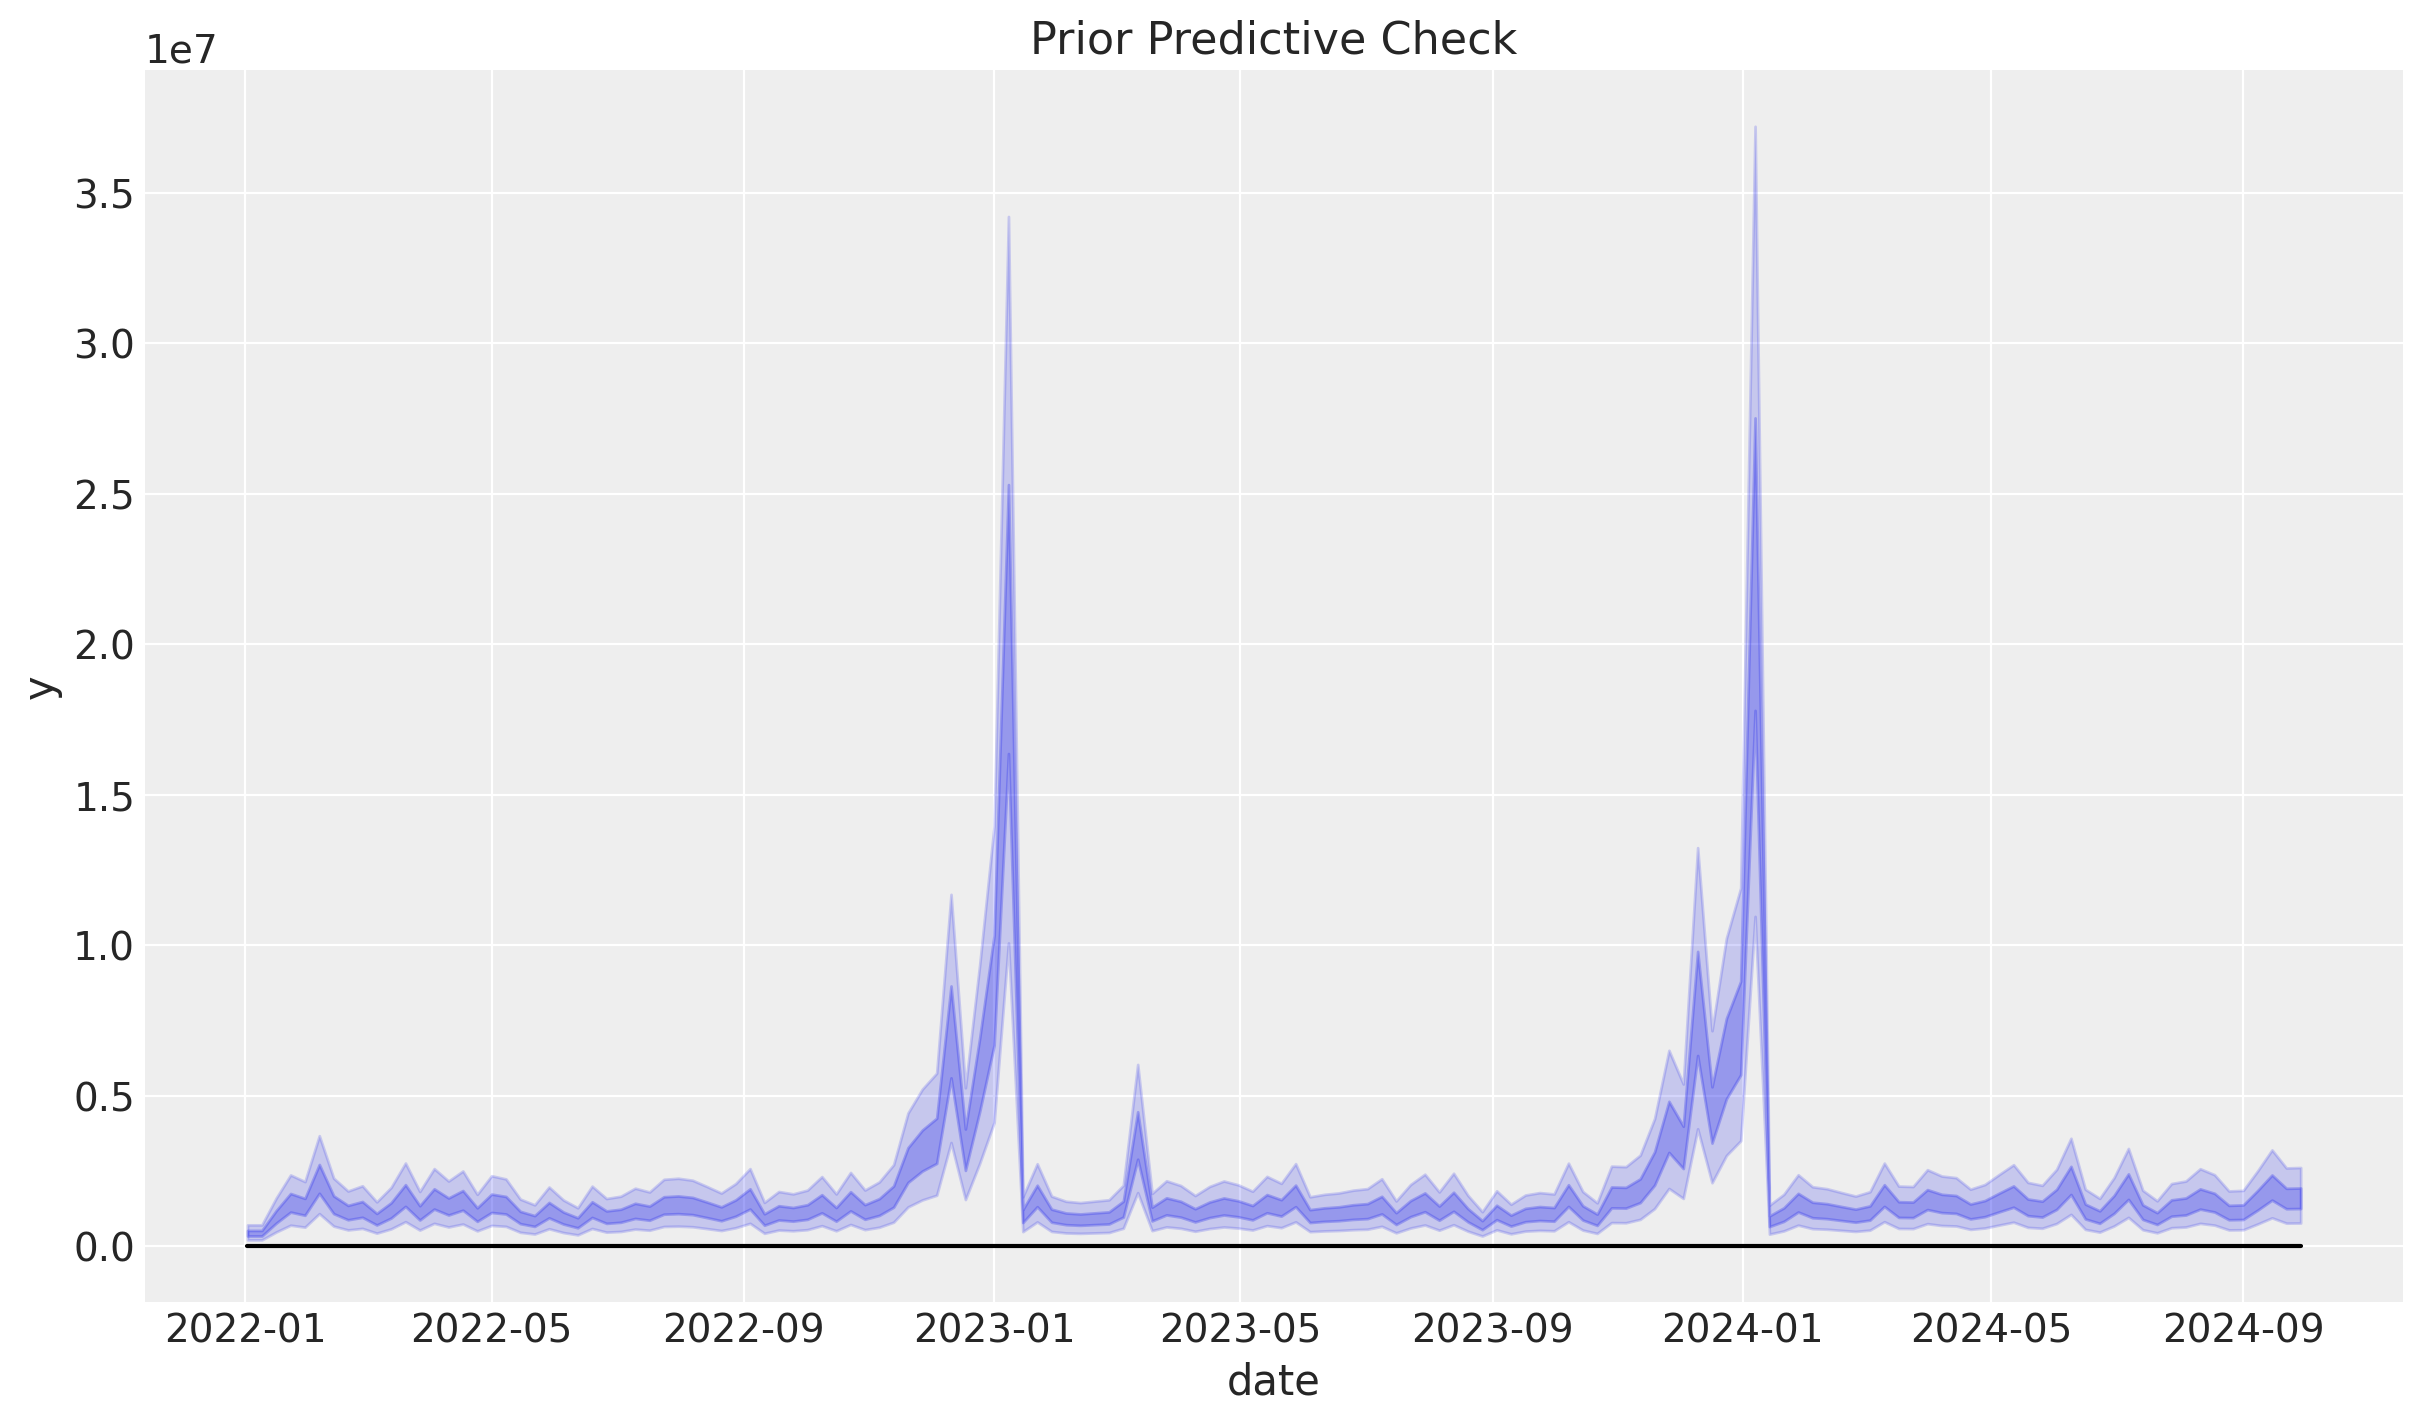

In [56]:
# Generate prior predictive samples
mmm.sample_prior_predictive(X, y, samples=2_000)

mmm.plot_prior_predictive();

In [57]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [58]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=4, random_seed=rng)

Output()

Output()

Output()

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

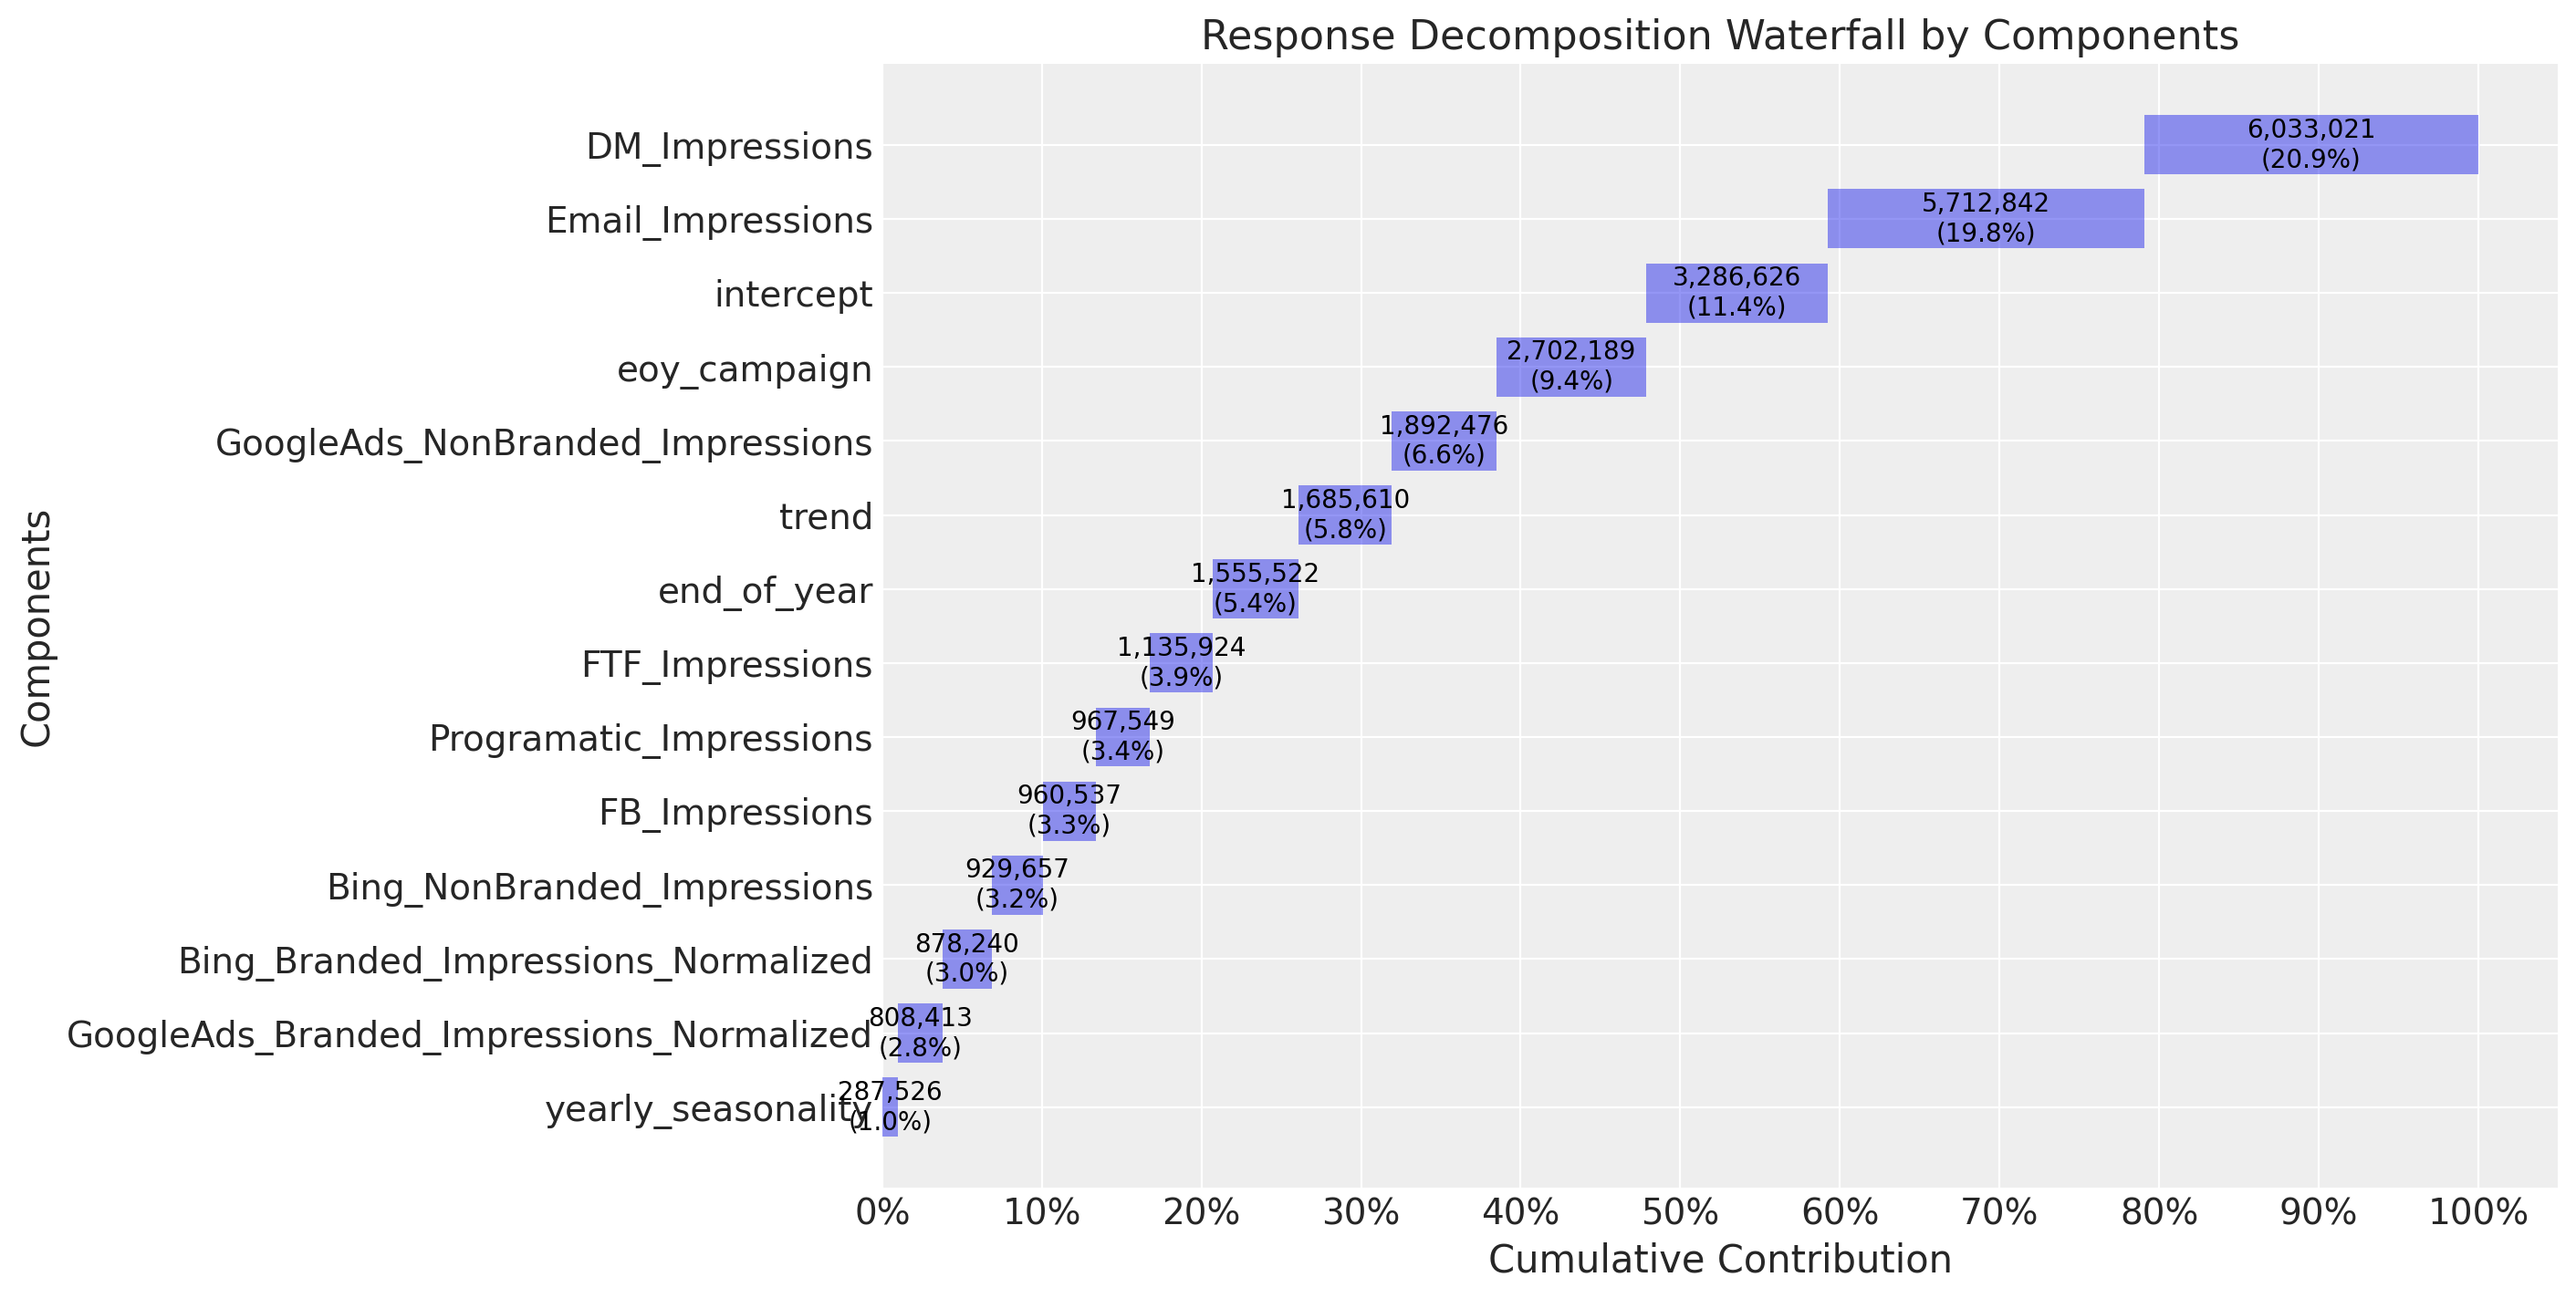

In [59]:
mmm.plot_waterfall_components_decomposition();

In [60]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

,Bing_Branded_Impressions_Normalized,Bing_NonBranded_Impressions,DM_Impressions,Email_Impressions,FB_Impressions,GoogleAds_Branded_Impressions_Normalized,GoogleAds_NonBranded_Impressions,Programatic_Impressions,FTF_Impressions,end_of_year,eoy_campaign,trend,yearly_seasonality,intercept
date,,,,,,,,,,,,,,
2022-01-02,180.866108,4973.000207,0.0,0.000000,0.0,5158.298700,4934.102769,0.0,0.000000,0.0,0.0,2649.385006,44286.179341,22823.791963
2022-01-09,452.238027,6791.574801,0.0,0.000000,0.0,2151.985622,19537.216645,0.0,25397.127066,0.0,0.0,2649.385006,50144.016106,22823.791963
2022-01-16,185.660599,8237.516813,0.0,0.000000,0.0,1906.779636,21029.329374,0.0,43677.537370,0.0,0.0,5994.580025,53778.629259,22823.791963
2022-01-23,5621.786946,13447.741914,0.0,135739.466951,0.0,25746.548766,20751.745972,0.0,22111.509236,0.0,0.0,8859.264397,55133.345479,22823.791963
2022-01-30,1371.251857,17907.077774,0.0,9833.848704,0.0,8045.715445,21860.190543,0.0,23844.167103,0.0,0.0,8036.963857,54271.152122,22823.791963


In [61]:
get_mean_contributions_over_time_df.sum().sum()

28836133.535211883

In [62]:
y.sum()

28155353.659999985

In [63]:
attr = get_mean_contributions_over_time_df.sum()/get_mean_contributions_over_time_df.sum().sum()*100
attr

,0
Bing_Branded_Impressions_Normalized,3.045625
Bing_NonBranded_Impressions,3.223930
DM_Impressions,20.921742
Email_Impressions,19.811401
FB_Impressions,3.331020
GoogleAds_Branded_Impressions_Normalized,2.803472
GoogleAds_NonBranded_Impressions,6.562864
Programatic_Impressions,3.355335
FTF_Impressions,3.939240
end_of_year,5.394349


In [66]:
attr.loc[[       'end_of_year', 'eoy_campaign', 'trend', 'intercept', 'yearly_seasonality']].sum()

33.005372120786745

In [67]:
X.columns

Index(['Date', 'Bing_Branded_Impressions', 'Bing_NonBranded_Impressions',
       'DM_Impressions', 'Email_Impressions', 'FB_Impressions',
       'GoogleAds_Branded_Impressions', 'GoogleAds_NonBranded_Impressions',
       'Programatic_Impressions', 'FTF_Impressions',
       'Bing_Branded_Impressions_Normalized',
       'GoogleAds_Branded_Impressions_Normalized', 'Consumer_Demand', 'CCI',
       'Unemployment_Rate', 'Annual_Inflation_Rate', 'Stock_Close', 'year',
       'month', 'dayofyear', 'eoy_campaign', 'end_of_year', 'trend'],
      dtype='object')